In [ ]:
!pip install lime
!pip install shap

     |████████████████████████████████| 276kB 24.8MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283858 sha256=cb20560318f0273d0b781e50334970f762919ec976e288a1bdc1903127fbd50f
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime
     |████████████████████████████████| 358kB 26.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491622 sha256=cc4bfab05aa7aac968a075c5287daa829bbff94ffa16e8f355fae83bea82ded0
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
import pandas as pd
import pickle

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
import sklearn.neighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

import xgboost as xgb #for building models

import lime #LIME package
import lime.lime_tabular #the type of LIIME analysis we’ll do
import shap #SHAP package
import time #some of the routines take a while so we monitor the time
import os #needed to use Environment Variables in Domino

In [ ]:
pd.set_option('display.max_columns',None)

In [ ]:
# 0.1 load data from file
from google.colab import files
import io

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving static_defenses_yards.csv to static_defenses_yards.csv
User uploaded file "static_defenses_yards.csv" with length 4999907 bytes


In [ ]:
static_defenses = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')),index_col="id")
static_defenses.head()

Unnamed: 0  defensivelinezonePlayers  deepzonePlayers  \
id                                                                        
2018090600:75:1            0                         0                1   
2018090600:146:1           1                         0                1   
2018090600:168:1           2                         0                1   
2018090600:190:1           3                         1                0   
2018090600:320:1           5                         1                0   

                  hookzonePlayers  curlzonePlayers  flatzonePlayers  \
id                                                                    
2018090600:75:1                 3                2                1   
2018090600:146:1                3                2                1   
2018090600:168:1                2                2                2   
2018090600:190:1                2                3                1   
2018090600:320:1                3                3                1   

                  defenseArea  defenseAreaCoverDefenders  width  height  \
id                                                                        
2018090600:75:1     194.31095                  194.31095  22.96   15.25   
2018090600:146:1    204.17725                  204.17725  29.22   12.57   
2018090600:168:1    277.65495                  277.65495  33.67   15.21   
2018090600:190:1    189.16960                  165.05520  26.42   12.91   
2018090600:320:1    187.12510                  153.20020  27.80   13.29   

                  numberQBs  numberWRs  numberTEs  numberRBs  numberFBs  \
id                                                                        
2018090600:75:1           1          2          1          1          1   
2018090600:146:1          1          3          1          1          0   
2018090600:168:1          1          2          1          2          0   
2018090600:190:1          1          3          1          1          0   
2018090600:320:1          1          3          1          1          0   

                  numberOffensivePlayersAnotherPosition  numberSafeties  \
id                                                                        
2018090600:75:1                                       0               3   
2018090600:146:1                                      0               2   
2018090600:168:1                                      0               2   
2018090600:190:1                                      0               3   
2018090600:320:1                                      0               2   

                  numberLBs  numberCBs strongSide  \
id                                                  
2018090600:75:1           2          2       left   
2018090600:146:1          2          3      right   
2018090600:168:1          2          3       left   
2018090600:190:1          1          3      right   
2018090600:320:1          3          3       left   

                  numberPlayersDefenseStrongSide  \
id                                                 
2018090600:75:1                                3   
2018090600:146:1                               3   
2018090600:168:1                               5   
2018090600:190:1                               2   
2018090600:320:1                               3   

                  numberPlayersDefenseWeakSide  \
id                                               
2018090600:75:1                              4   
2018090600:146:1                             4   
2018090600:168:1                             2   
2018090600:190:1                             5   
2018090600:320:1                             5   

                  numberPlayersOffenseStrongSide  \
id                                                 
2018090600:75:1                                3   
2018090600:146:1                               2   
2018090600:168:1                               4   
2018090600:190:1                               2   
2018090600:320:1

In [ ]:
static_defenses.drop(["Unnamed: 0"],axis=1,inplace=True)

In [ ]:
static_defenses.replace({"right":0,"left":1},inplace=True)

#Eliminar outliers

In [ ]:
#load dataset
pickle_file = open('outliers_minpts10_rs_3.pickle','rb')
outliers = pickle.load(pickle_file)
pickle_file.close()

In [ ]:
for play in list(outliers):
    static_defenses.drop(play,inplace=True)

#Eliminar big plays

In [ ]:
static_defenses["playResult"].max()

97

In [ ]:
static_defenses["playResult"].min()

-78

##Big plays ofensivas

In [ ]:
static_defenses["playResult"].mean()

6.974169966494061

Vamos a seguir el siguiente criterio: a partir de 16 yardas es una big play en pase

Fuente: https://www.espn.com/blog/nflnation/post/_/id/73001/nfl-big-plays-who-and-what-makes-them

In [ ]:
len(static_defenses[static_defenses["playResult"]>=16])

2603

In [ ]:
len(static_defenses[static_defenses["playResult"]>=16]) / len(static_defenses) * 100

15.857447456594578

Representan el 16% de las jugadas, podríamos al menos estudiarlo por separarlo

In [ ]:
big_plays_offense = static_defenses[static_defenses["playResult"]>=16]

In [ ]:
static_defenses.drop(static_defenses[static_defenses["playResult"]>=16].index,inplace=True)

In [ ]:
len(static_defenses)

13812

##Big plays defensivas

In [ ]:
static_defenses[static_defenses["playResult"]<0]["playResult"].median()

-7.0

In [ ]:
static_defenses[static_defenses["playResult"]<=-7]

defensivelinezonePlayers  deepzonePlayers  \
id                                                              
2018090600:776:1                           3                1   
2018090600:949:1                           0                0   
2018090600:1568:1                          0                0   
2018090600:2503:1                          0                1   
2018090600:3626:1                          2                0   
...                                      ...              ...   
2018123015:1694:17                         3                1   
2018123015:1921:17                         0                0   
2018123015:2469:17                         1                1   
2018123015:3089:17                         0                0   
2018123015:3601:17                         2                0   

                    hookzonePlayers  curlzonePlayers  flatzonePlayers  \
id                                                                      
2018090600:776:1                  2                1                1   
2018090600:949:1                  2                3                2   
2018090600:1568:1                 1                6                0   
2018090600:2503:1                 2                2                2   
2018090600:3626:1                 2                4                0   
...                             ...              ...              ...   
2018123015:1694:17                1                1                1   
2018123015:1921:17                3                2                2   
2018123015:2469:17                2                1                2   
2018123015:3089:17                1                5                1   
2018123015:3601:17                1                4                0   

                    defenseArea  defenseAreaCoverDefenders  width  height  \
id                                                                          
2018090600:776:1      234.84220                  163.61555  29.95   15.29   
2018090600:949:1      129.48690                  129.48690  32.42    7.89   
2018090600:1568:1     162.57650                  162.57650  22.58   12.45   
2018090600:2503:1     240.30520                  240.30520  33.16   12.69   
2018090600:3626:1     154.37785                  147.44340  24.25   11.99   
...                         ...                        ...    ...     ...   
2018123015:1694:17    206.35020                  137.89705  27.53   14.91   
2018123015:1921:17    124.16935                  124.16935  36.07    8.24   
2018123015:2469:17    266.35375                  261.58220  31.15   16.07   
2018123015:3089:17    233.56345                  233.56345  26.20   12.97   
2018123015:3601:17    131.03325                   93.42570  18.39   12.93   

                    numberQBs  numberWRs  numberTEs  numberRBs  numberFBs  \
id                                                                          
2018090600:776:1            1          3          1          1          0   
2018090600:949:1            1          3          1          1          0   
2018090600:1568:1           1          3          1          1          0   
2018090600:2503:1           1          3          1          1          0   
2018090600:3626:1           1          2          2          1          0   
...                       ...        ...        ...        ...        ...   
2018123015:1694:17          1          3          1          1          0   
2018123015:1921:17          1          3          1          1          0   
2018123015:2469:17          1          3          1          1          0   
2018123015:3089:17          1          3          1          1          0   
2018123015:3601:17          1          3          1          1          0   

                    numberOffensivePlayersAnotherPosition  numberSafeties  \
id                                                                          
2018090600:776:1                                        0         

In [ ]:
big_play_defense = static_defenses[static_defenses["playResult"]<=-7]

In [ ]:
static_defenses.drop(static_defenses[static_defenses["playResult"]<=-7].index,inplace=True)

#Normalización de los datos

In [ ]:
scaler = preprocessing.StandardScaler()
static_defenses1 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.MinMaxScaler()
static_defenses2 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.RobustScaler()
static_defenses3 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

In [ ]:
scaler = preprocessing.PowerTransformer()
static_defenses4 = scaler.fit_transform(static_defenses.drop(["playResult"],axis=1))

#PCA

In [ ]:
pca_ss = PCA ()
X_pca_ss = pca_ss.fit_transform(static_defenses1)
X_pca_ss.shape

(16415, 35)

In [ ]:
pca_mms = PCA ()
X_pca_mms = pca_mms.fit_transform(static_defenses2)
X_pca_mms.shape

(16415, 35)

In [ ]:
pca_rs = PCA ()
X_pca_rs = pca_rs.fit_transform(static_defenses3)
X_pca_rs.shape

(16415, 35)

In [ ]:
pca_pt = PCA ()
X_pca_pt = pca_pt.fit_transform(static_defenses4)
X_pca_pt.shape

(16415, 35)

In [ ]:
exp_var_cumul = np.cumsum(pca_ss.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Para este 14 componentes

In [ ]:
exp_var_cumul = np.cumsum(pca_mms.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Para este 8 componentes

In [ ]:
exp_var_cumul = np.cumsum(pca_rs.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "Número de componentes", "y": "Variabilidad"}
)

Para este 5 componentes

In [ ]:
exp_var_cumul = np.cumsum(pca_pt.explained_variance_ratio_)

px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

Para este 13 componentes

#Nuevos datasets

In [ ]:
X_pca_ss = PCA(n_components = 14).fit_transform(static_defenses1)
X_pca_ss.shape

(16415, 14)

In [ ]:
X_pca_mms = PCA(n_components = 8).fit_transform(static_defenses2)
X_pca_mms.shape

(16415, 8)

In [ ]:
X_pca_rs = PCA(n_components = 5).fit_transform(static_defenses3)
X_pca_rs.shape

(16415, 5)

In [ ]:
X_pca_pt = PCA(n_components = 13).fit_transform(static_defenses4)
X_pca_pt.shape

(16415, 13)

#KNN

##StandardScaler

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

0         1         2         3         4         5         6  \
0 -0.796762 -2.471063  0.379461  1.883567  2.239643 -0.251088 -1.068814   
1 -0.073693 -1.840949  1.472369 -0.208184 -0.523825  0.593290 -1.869383   
2  2.280870 -2.498068 -3.336658  1.542836  0.516549 -0.466786 -0.256590   
3 -1.676263  0.859091  0.705002 -0.887539  2.034706 -1.883531 -0.668118   
4  0.181136  0.085060 -2.481506 -0.073147  0.939431  2.312027  0.419618   

          7         8         9        10        11        12        13  \
0  1.946789  1.118578  1.753101  3.898088 -2.202851 -0.734654  0.513206   
1  0.429094  0.173241 -0.302866 -0.498868  0.308037 -0.453467  0.379689   
2 -0.182320 -2.152436  3.307756 -1.291832 -0.108191 -0.009525 -0.236026   
3  0.783035 -0.891376 -0.172153  0.556752 -0.397043  0.549090 -0.754145   
4 -0.602377 -0.245801 -1.052902 -0.620641  0.135919 -0.282345 -0.459050   

   playResult  
0          10  
1           0  
2           0  
3           4  
4           0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_ss, static_defenses["playResult"], test_size=0.2)

Min Value uniform : 4.380324445423694 (29)
Min Value distance : 4.381041692733392 (29)


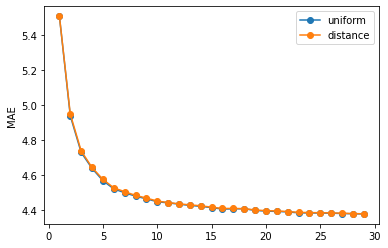

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 10, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_ss):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['playResult'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 



In [ ]:
# constructor
n_neighbors = 29
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
mae = mean_absolute_error(y_test,y_pred)
print ('MAE', mae)

MAE 4.392279348644331


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



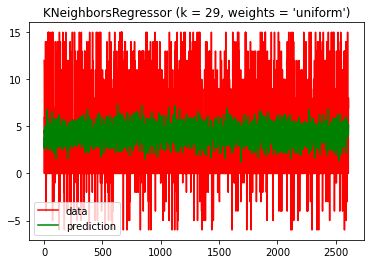

In [ ]:

from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

##MinMaxScaler

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

0         1         2         3         4         5         6  \
0 -0.774207 -2.468463  0.494566  1.864442  2.134126 -0.167689 -1.035529   
1 -0.050022 -1.812451  1.506638 -0.269917 -0.550293  0.652475 -1.825971   
2  2.290472 -2.538432 -3.218413  1.618976  0.525982 -0.480004 -0.323774   
3 -1.455413 -1.673324  2.751002 -1.874452  0.495801 -0.928747 -0.089102   
4 -1.647651  0.858845  0.729530 -0.845751  2.025989 -1.865085 -0.695295   

          7         8         9        10        11        12        13  \
0  2.170305  1.481364  1.282113 -4.053152  1.791275 -0.521982  0.693632   
1  0.446371  0.143673 -0.281565  0.558406 -0.310550 -0.510448  0.446715   
2 -0.103402 -1.648391  3.647438  0.568316 -0.831422  0.013317 -0.263231   
3  1.235334 -0.949319 -0.706386  0.283102 -0.117368 -0.609669  0.547714   
4  0.816665 -0.857215 -0.145110 -0.575788  0.279939  0.620699 -0.725182   

   playResult  
0          10  
1           0  
2           0  
3          33  
4           4

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 10, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_ss):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['playResult'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 



Min Value uniform : 7.979604783846378 (29)


In [ ]:
# constructor
n_neighbors = 7
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
mae = mean_absolute_error(y_test,y_pred)
print ('MAE', mae)

MAE 8.383012053435445


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



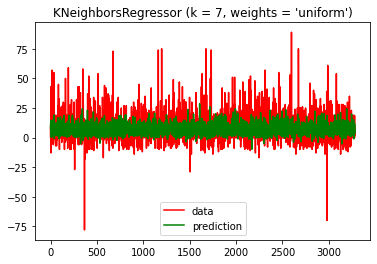

In [ ]:

from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

##RobustScaler

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

0         1         2         3         4         5         6  \
0 -0.774207 -2.468463  0.494566  1.864442  2.134126 -0.167689 -1.035529   
1 -0.050022 -1.812451  1.506638 -0.269917 -0.550293  0.652475 -1.825971   
2  2.290472 -2.538432 -3.218413  1.618976  0.525982 -0.480004 -0.323774   
3 -1.455413 -1.673324  2.751002 -1.874452  0.495801 -0.928747 -0.089102   
4 -1.647651  0.858845  0.729530 -0.845751  2.025989 -1.865085 -0.695295   

          7         8         9        10        11        12        13  \
0  2.170305  1.481364  1.282113 -4.053152  1.791275 -0.521982  0.693632   
1  0.446371  0.143673 -0.281565  0.558406 -0.310550 -0.510448  0.446715   
2 -0.103402 -1.648391  3.647438  0.568316 -0.831422  0.013317 -0.263231   
3  1.235334 -0.949319 -0.706386  0.283102 -0.117368 -0.609669  0.547714   
4  0.816665 -0.857215 -0.145110 -0.575788  0.279939  0.620699 -0.725182   

   playResult  
0          10  
1           0  
2           0  
3          33  
4           4

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 10, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_ss):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['playResult'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 



Min Value uniform : 7.979604783846378 (29)


In [ ]:
# constructor
n_neighbors = 7
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
mae = mean_absolute_error(y_test,y_pred)
print ('MAE', mae)

MAE 8.383012053435445


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



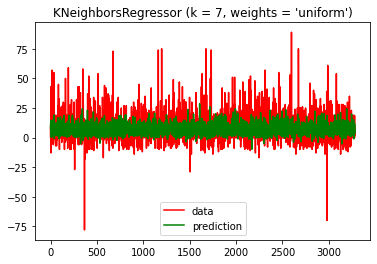

In [ ]:

from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

##PowerTransformer

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

0         1         2         3         4         5         6  \
0 -0.774207 -2.468463  0.494566  1.864442  2.134126 -0.167689 -1.035529   
1 -0.050022 -1.812451  1.506638 -0.269917 -0.550293  0.652475 -1.825971   
2  2.290472 -2.538432 -3.218413  1.618976  0.525982 -0.480004 -0.323774   
3 -1.455413 -1.673324  2.751002 -1.874452  0.495801 -0.928747 -0.089102   
4 -1.647651  0.858845  0.729530 -0.845751  2.025989 -1.865085 -0.695295   

          7         8         9        10        11        12        13  \
0  2.170305  1.481364  1.282113 -4.053152  1.791275 -0.521982  0.693632   
1  0.446371  0.143673 -0.281565  0.558406 -0.310550 -0.510448  0.446715   
2 -0.103402 -1.648391  3.647438  0.568316 -0.831422  0.013317 -0.263231   
3  1.235334 -0.949319 -0.706386  0.283102 -0.117368 -0.609669  0.547714   
4  0.816665 -0.857215 -0.145110 -0.575788  0.279939  0.620699 -0.725182   

   playResult  
0          10  
1           0  
2           0  
3          33  
4           4

In [ ]:
from sklearn import neighbors
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

cv = KFold(n_splits = 10, shuffle = False) #


for i, weights in enumerate(['uniform', 'distance']):
   total_scores = []
   for n_neighbors in range(1,30):
       fold_accuracy = []
       knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
       # verificar cada uno de los modelos con validación cruzada.
       for train_fold, test_fold in cv.split(train_ss):
          # División train test aleatoria
          f_train = train_ss.loc[train_fold]
          f_test = train_ss.loc[test_fold]
          # entrenamiento y ejecución del modelo
          knn.fit( X = f_train.drop(["playResult"],axis=1), y = f_train['playResult'])
          y_pred = knn.predict(X = f_test.drop(['playResult'], axis = 1))
          # evaluación del modelo
          mae = mean_absolute_error(f_test['playResult'], y_pred)
          fold_accuracy.append(mae)
       total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
   plt.plot(range(1,len(total_scores)+1), total_scores, 
             marker='o', label=weights)
   print ('Min Value ' +  weights + " : " +  str(min(total_scores)) +" (" + str(np.argmin(total_scores) + 1) + ")")
   plt.ylabel('MAE')      
    

plt.legend()
plt.show() 



Min Value uniform : 7.979604783846378 (29)


In [ ]:
# constructor
n_neighbors = 7
weights = 'uniform'
knn = neighbors.KNeighborsRegressor(n_neighbors= n_neighbors, weights=weights) 
# fit and predict

knn.fit( X = X_train, y = y_train)
y_pred = knn.predict(X = X_test)
mae = mean_absolute_error(y_test,y_pred)
print ('MAE', mae)

MAE 8.383012053435445


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



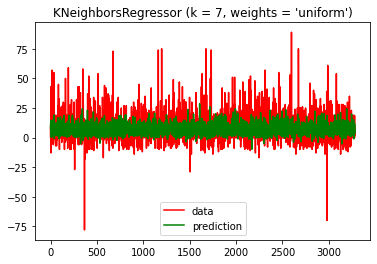

In [ ]:

from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors,
                                                                weights))

plt.show()

#Decision Trees

##Sin normalizar

In [ ]:
static_defenses.head()

defensivelinezonePlayers  deepzonePlayers  hookzonePlayers  \
id                                                                             
2018090600:75:1                          0                1                3   
2018090600:146:1                         0                1                3   
2018090600:168:1                         0                1                2   
2018090600:190:1                         1                0                2   
2018090600:320:1                         1                0                3   

                  curlzonePlayers  flatzonePlayers  defenseArea  \
id                                                                
2018090600:75:1                 2                1    194.31095   
2018090600:146:1                2                1    204.17725   
2018090600:168:1                2                2    277.65495   
2018090600:190:1                3                1    189.16960   
2018090600:320:1                3                1    187.12510   

                  defenseAreaCoverDefenders  width  height  numberQBs  \
id                                                                      
2018090600:75:1                   194.31095  22.96   15.25          1   
2018090600:146:1                  204.17725  29.22   12.57          1   
2018090600:168:1                  277.65495  33.67   15.21          1   
2018090600:190:1                  165.05520  26.42   12.91          1   
2018090600:320:1                  153.20020  27.80   13.29          1   

                  numberWRs  numberTEs  numberRBs  numberFBs  \
id                                                             
2018090600:75:1           2          1          1          1   
2018090600:146:1          3          1          1          0   
2018090600:168:1          2          1          2          0   
2018090600:190:1          3          1          1          0   
2018090600:320:1          3          1          1          0   

                  numberOffensivePlayersAnotherPosition  numberSafeties  \
id                                                                        
2018090600:75:1                                       0               3   
2018090600:146:1                                      0               2   
2018090600:168:1                                      0               2   
2018090600:190:1                                      0               3   
2018090600:320:1                                      0               2   

                  numberLBs  numberCBs  strongSide  \
id                                                   
2018090600:75:1           2          2           1   
2018090600:146:1          2          3           0   
2018090600:168:1          2          3           1   
2018090600:190:1          1          3           0   
2018090600:320:1          3          3           1   

                  numberPlayersDefenseStrongSide  \
id                                                 
2018090600:75:1                                3   
2018090600:146:1                               3   
2018090600:168:1                               5   
2018090600:190:1                               2   
2018090600:320:1                               3   

                  numberPlayersDefenseWeakSide  \
id                                               
2018090600:75:1                              4   
2018090600:146:1                             4   
2018090600:168:1                             2   
2018090600:190:1                             5   
2018090600:320:1                             5   

                  numberPlayersOffenseStrongSide  \
id                                                 
2018090600:75:1                                3   
2018090600:146:1                               2   
2018090600:168:1                               4   
2018090600:190:1                               2   
2018090600:320:1                               3   

                  numberPlayersOffenseWe

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(static_defenses.drop(["playResult"],axis=1),static_defenses["playResult"],test_size=0.2)

In [ ]:
xgb_model = xgb.train({'objective':'reg:linear'}, xgb.DMatrix(X_train, label=y_train))

[15:11:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
import sklearn.ensemble
sk_xgb = sklearn.ensemble.GradientBoostingRegressor()
sk_xgb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
# Tree on XGBoost
explainerXGB = shap.TreeExplainer(xgb_model)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

In [ ]:
# Tree on Scikit GBT
explainerSKGBT = shap.TreeExplainer(sk_xgb)
shap_values_SKGBT_test = explainerSKGBT.shap_values(X_test)
shap_values_SKGBT_train = explainerSKGBT.shap_values(X_train)

In [ ]:
# XGBoost
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)
# Scikit GBT
df_shap_SKGBT_test = pd.DataFrame(shap_values_SKGBT_test, columns=X_test.columns.values)
df_shap_SKGBT_train = pd.DataFrame(shap_values_SKGBT_train, columns=X_train.columns.values)
# Random Forest
#df_shap_RF_test = pd.DataFrame(shap_values_RF_test, columns=X_test.columns.values)
#df_shap_RF_train = pd.DataFrame(shap_values_RF_train, columns=X_train.columns.values)

In [ ]:
# if a feature has 10 or less unique values then treat it as categorical
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()
 
# LIME has one explainer for all models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
feature_names=X_train.columns.values.tolist(),
class_names=['playResult'],
categorical_features=categorical_features,
verbose=True, mode='regression')

In [ ]:
# j will be the record we explain
j = 0

In [ ]:
shap.initjs()
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

In [ ]:
expXGB = explainer.explain_instance(X_test.values[j], xgb_model.predict, num_features=5)
expXGB.show_in_notebook(show_table=True)

AttributeError: ignored

In [ ]:
shap.initjs()
shap.force_plot(explainerSKGBT.expected_value, shap_values_SKGBT_test[j], X_test.iloc[[j]])

In [ ]:
expSKGBT = explainer.explain_instance(X_test.values[j], sk_xgb.predict, num_features=5)
expSKGBT.show_in_notebook(show_table=True)

Intercept 10.096356927650037
Prediction_local [7.75730115]
Right: 6.511210056897207


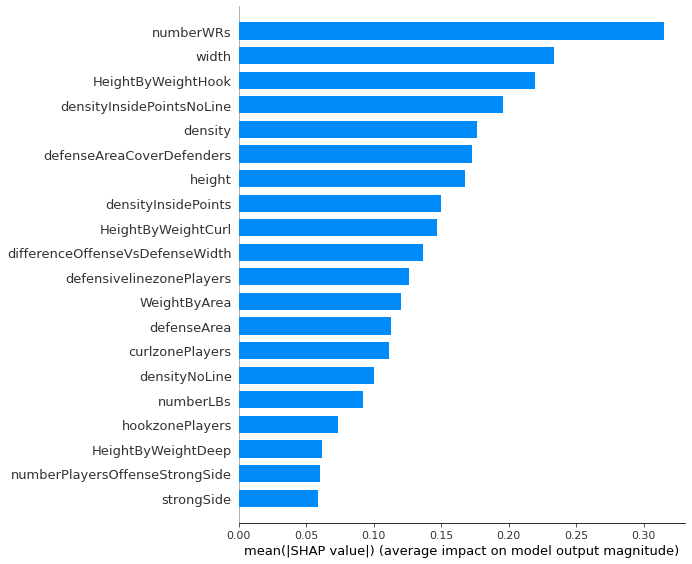

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")

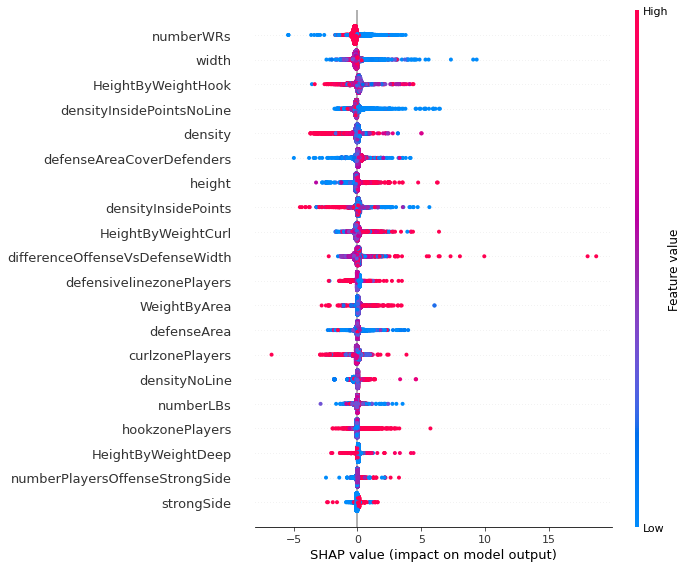

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train)

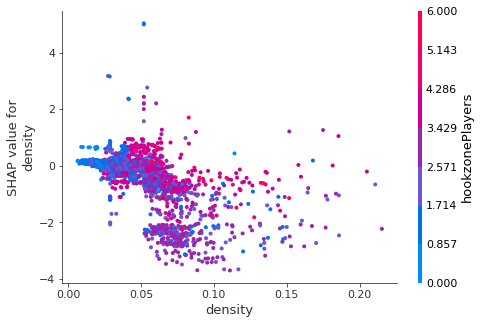

In [ ]:
shp_plt = shap.dependence_plot("density", shap_values_XGB_train, X_train)

###Probando las nuevas variables

Primero escogemos las nuevas variables

In [ ]:
#las primeras features son con SHAP y las segunda las que indica un modelo de bigml

#new_df = static_defenses[["numberWRs","width","HeightByWeightHook","densityInsidePointsNoLine","density","defenseAreaCoverDefenders","height","playResult"]]
new_df = static_defenses[["differenceOffenseVsDefenseWidth","height","densityInsidePointsNoLine","width","WeightByArea","defenseAreaCoverDefenders","numberSafeties","playResult"]]
new_df.head()

differenceOffenseVsDefenseWidth  height  \
id                                                          
2018090600:75:1                             -0.63   15.25   
2018090600:146:1                            -1.15   12.57   
2018090600:168:1                             0.71   15.21   
2018090600:190:1                            -3.11   12.91   
2018090600:320:1                            -4.82   13.29   

                  densityInsidePointsNoLine  width  WeightByArea  \
id                                                                 
2018090600:75:1                    6.974268  22.96      3.376032   
2018090600:146:1                   6.975511  29.22      3.178611   
2018090600:168:1                   6.985594  33.67      2.337434   
2018090600:190:1                   6.969707  26.42      3.192871   
2018090600:320:1                   7.980418  27.80      4.281979   

                  defenseAreaCoverDefenders  numberSafeties  playResult  
id                                                                       
2018090600:75:1                   194.31095               3          10  
2018090600:146:1                  204.17725               2           0  
2018090600:168:1                  277.65495               2           0  
2018090600:190:1                  165.05520               3          33  
2018090600:320:1                  153.20020               2           4

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) #
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 


total_scores = []
for i in range(1,30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i)
    # verificar cada uno de los modelos con validación cruzada.
    for train_fold, test_fold in cv.split(new_df):
      # División train test aleatoria
      f_train = new_df.loc[train_fold]
      f_test = new_df.loc[test_fold]
      # entrenamiento y ejecución del modelo
      dt.fit( X = f_train.drop(['playResult'], axis=1), 
                            y = f_train['playResult'])
      y_pred = dt.predict(X = f_test.drop(['playResult'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['playResult'], y_pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value  :' +  str(min(total_scores)) +' (' + str(np.argmin(total_scores) + 1) + ')')
plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

KeyError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_df.drop(["playResult"],axis=1),new_df["playResult"],test_size=0.2)

In [ ]:
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
mae = mean_absolute_error(y_test, y_pred)
print ('MAE', mae)


MAE 7.830675455004703


arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


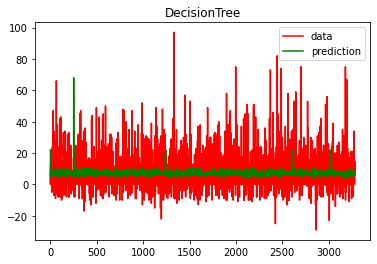

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

##StandardScaler

In [ ]:
train_ss = pd.DataFrame(X_pca_ss)
train_ss["playResult"] = static_defenses["playResult"].values
train_ss.head()

0         1         2         3         4         5         6  \
0 -0.774207 -2.468463  0.494566  1.864442  2.134127 -0.167691 -1.035526   
1 -0.050022 -1.812451  1.506638 -0.269917 -0.550293  0.652476 -1.825973   
2  2.290472 -2.538432 -3.218413  1.618976  0.525982 -0.480004 -0.323774   
3 -1.455413 -1.673324  2.751002 -1.874452  0.495801 -0.928747 -0.089101   
4 -1.647651  0.858845  0.729530 -0.845751  2.025989 -1.865084 -0.695297   

          7         8         9        10        11        12        13  \
0  2.170306  1.481362  1.282110 -4.053163  1.791275 -0.521978  0.693602   
1  0.446370  0.143676 -0.281564  0.558414 -0.310545 -0.510446  0.446728   
2 -0.103402 -1.648391  3.647437  0.568315 -0.831420  0.013318 -0.263238   
3  1.235334 -0.949320 -0.706387  0.283100 -0.117369 -0.609669  0.547709   
4  0.816665 -0.857215 -0.145108 -0.575783  0.279938  0.620697 -0.725165   

   playResult  
0          10  
1           0  
2           0  
3          33  
4           4

No handles with labels found to put in legend.


Min Value  :7.805285947393244 (1)


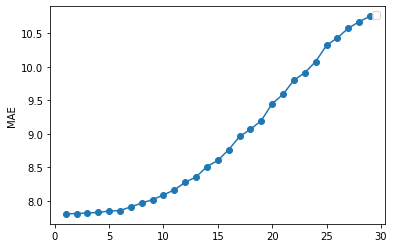

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) #
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 


total_scores = []
for i in range(1,30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i)
    # verificar cada uno de los modelos con validación cruzada.
    for train_fold, test_fold in cv.split(train_ss):
      # División train test aleatoria
      f_train = train_ss.loc[train_fold]
      f_test = train_ss.loc[test_fold]
      # entrenamiento y ejecución del modelo
      dt.fit( X = f_train.drop(['playResult'], axis=1), 
                            y = f_train['playResult'])
      y_pred = dt.predict(X = f_test.drop(['playResult'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['playResult'], y_pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value  :' +  str(min(total_scores)) +' (' + str(np.argmin(total_scores) + 1) + ')')
plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

###Ejecución

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ss.drop(["playResult"],axis=1),train_ss["playResult"],test_size=0.2)

In [ ]:
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
mae = mean_absolute_error(y_test, y_pred)
print ('MAE', mae)


MAE 8.014497294284967


arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


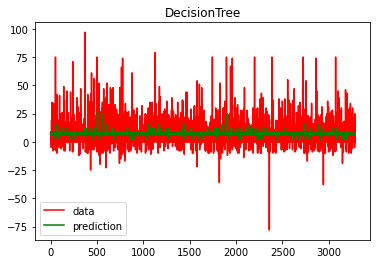

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

###Ejecución train vs train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ss.drop(["playResult"],axis=1),train_ss["playResult"],test_size=0.2)

In [ ]:
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_train)
mae = mean_absolute_error(y_train, y_pred)
print ('MAE', mae)


MAE 7.714754498541868


arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


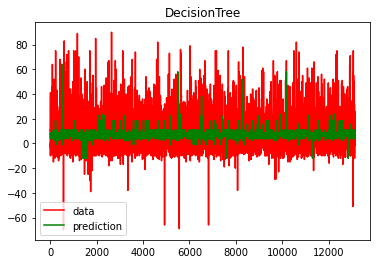

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_train.shape[0]))
plt.plot(xx, y_train, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

###Datos que más se han acercado a predecir

In [ ]:
y_pred

array([ 5.6065512 ,  6.96189024, 10.56842105, ...,  6.86380869,
        6.88067855,  4.09259259])

In [ ]:
y_test

4640     35
3942     33
9849      5
4903     13
533      18
         ..
6743     15
12026    13
879       0
7671     -1
2490      0
Name: playResult, Length: 3283, dtype: int64

In [ ]:
y_pred.max()

75.0

In [ ]:
list(y_pred).index(75)

1165

In [ ]:
y_pred[1165]

75.0

In [ ]:
y_test.values[1165]

4

Predice 75 cuando es 4, un valor un poco atípico.

In [ ]:
for value in y_pred:
  pass

###SHAP y LIME

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ss.drop(["playResult"],axis=1),train_ss["playResult"],test_size=0.2)

In [ ]:
xgb_model = xgb.train({'objective':'reg:linear'}, xgb.DMatrix(X_train, label=y_train))

[14:28:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
import sklearn.ensemble
sk_xgb = sklearn.ensemble.GradientBoostingRegressor()
sk_xgb.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
rf = sklearn.ensemble.RandomForestRegressor() #### este no
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
# Tree on XGBoost
explainerXGB = shap.TreeExplainer(xgb_model)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

In [ ]:
# Tree on Scikit GBT
explainerSKGBT = shap.TreeExplainer(sk_xgb)
shap_values_SKGBT_test = explainerSKGBT.shap_values(X_test)
shap_values_SKGBT_train = explainerSKGBT.shap_values(X_train)

In [ ]:
# Tree on Random Forestexplainer
explainerRF = shap.TreeExplainer(rf) ### este tampoco
shap_values_RF_test = explainerRF.shap_values(X_test)
shap_values_RF_train = explainerRF.shap_values(X_train)

In [ ]:
# XGBoost
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)
# Scikit GBT
df_shap_SKGBT_test = pd.DataFrame(shap_values_SKGBT_test, columns=X_test.columns.values)
df_shap_SKGBT_train = pd.DataFrame(shap_values_SKGBT_train, columns=X_train.columns.values)
# Random Forest
#df_shap_RF_test = pd.DataFrame(shap_values_RF_test, columns=X_test.columns.values)
#df_shap_RF_train = pd.DataFrame(shap_values_RF_train, columns=X_train.columns.values)

In [ ]:
# if a feature has 10 or less unique values then treat it as categorical
categorical_features = np.argwhere(np.array([len(set(X_train.values[:,x]))
for x in range(X_train.values.shape[1])]) <= 10).flatten()
 
# LIME has one explainer for all models
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
feature_names=X_train.columns.values.tolist(),
class_names=['price'],
categorical_features=categorical_features,
verbose=True, mode='regression')

In [ ]:
# j will be the record we explain
j = 0

In [ ]:
shap.initjs()
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])

In [ ]:
expXGB = explainer.explain_instance(X_test.values[j], xgb_model.predict, num_features=5)
expXGB.show_in_notebook(show_table=True)

AttributeError: ignored

In [ ]:
shap.initjs()
shap.force_plot(explainerSKGBT.expected_value, shap_values_SKGBT_test[j], X_test.iloc[[j]])

In [ ]:
expSKGBT = explainer.explain_instance(X_test.values[j], sk_xgb.predict, num_features=5
expSKGBT.show_in_notebook(show_table=True)

Intercept 6.99997976620162
Prediction_local [9.36445114]
Right: 7.628042284595424


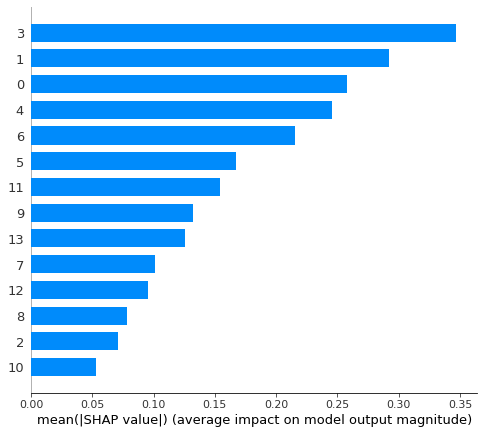

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")  

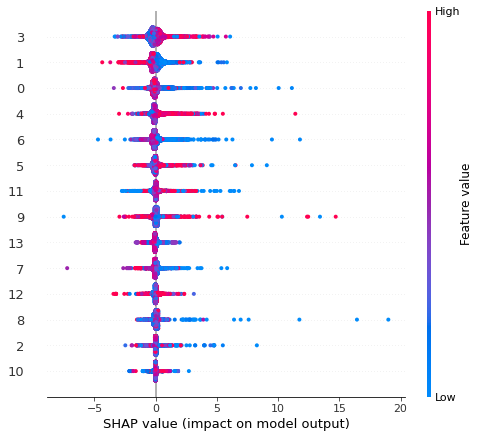

In [ ]:
shap.summary_plot(shap_values_XGB_train, X_train)

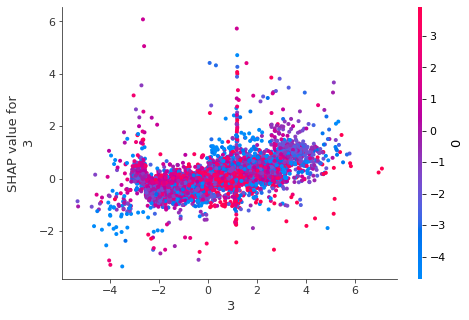

In [ ]:
shp_plt = shap.dependence_plot(3, shap_values_XGB_train, X_train)

##MinMaxScaler

In [ ]:
train_mms = pd.DataFrame(X_pca_mms)
train_mms["playResult"] = static_defenses["playResult"].values
train_mms.head()

0         1         2         3         4         5         6  \
0  0.688622  0.202951  0.281656 -0.440485  0.152258  0.661694  0.386370   
1  0.103348 -0.590002  0.120717 -0.273776 -0.254969  0.187258 -0.179997   
2  0.856377  0.087110  0.068605 -0.331777  0.508102  0.012069 -0.071603   
3 -0.442417 -0.057522 -0.329294 -0.254068 -0.346503 -0.047675  0.123036   
4  0.181359  0.717131 -0.253822  0.075266  0.077892  0.127123  0.097544   

          7  playResult  
0  0.090922          10  
1 -0.094330           0  
2  0.063810           0  
3 -0.219887          33  
4 -0.328806           4

No handles with labels found to put in legend.


Min Value  :4.352378349329421 (3)


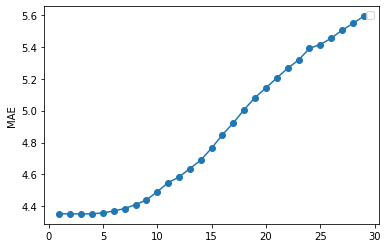

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) #
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 


total_scores = []
for i in range(1,30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i)
    # verificar cada uno de los modelos con validación cruzada.
    for train_fold, test_fold in cv.split(train_mms):
      # División train test aleatoria
      f_train = train_ss.loc[train_fold]
      f_test = train_ss.loc[test_fold]
      # entrenamiento y ejecución del modelo
      dt.fit( X = f_train.drop(['playResult'], axis=1), 
                            y = f_train['playResult'])
      y_pred = dt.predict(X = f_test.drop(['playResult'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['playResult'], y_pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value  :' +  str(min(total_scores)) +' (' + str(np.argmin(total_scores) + 1) + ')')
plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_mms.drop(["playResult"],axis=1),train_mms["playResult"],test_size=0.2)

In [ ]:
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
mae = mean_absolute_error(y_test, y_pred)
print ('MAE', mae)


MAE 4.364333846865527


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



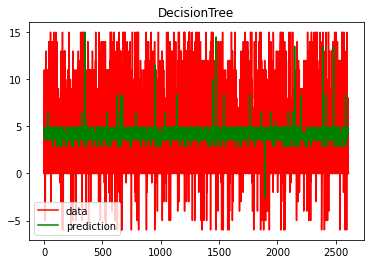

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

###Ejecución train vs train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_mms.drop(["playResult"],axis=1),train_mms["playResult"],test_size=0.2)

In [ ]:
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_train)
mae = mean_absolute_error(y_train, y_pred)
print ('MAE', mae)


MAE 7.691176139877451


arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


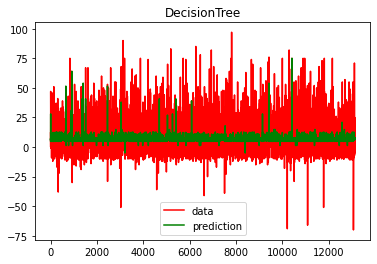

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_train.shape[0]))
plt.plot(xx, y_train, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

##RobustScaler

In [ ]:
train_rs = pd.DataFrame(X_pca_rs)
train_rs["playResult"] = static_defenses["playResult"].values
train_rs.head()

0         1         2         3         4  playResult
0 -2.846079 -1.235577  0.576748 -1.380872 -0.401050          10
1 -2.575505 -1.551563  0.204190 -1.135923 -1.045551           0
2 -3.318432 -0.086195 -1.002166 -1.999377 -1.458847           0
3 -2.338349 -2.287407  0.791533 -1.048362 -2.000529          33
4 -2.728644 -1.678299  1.495721  1.129192  0.054277           4

No handles with labels found to put in legend.


Min Value  :4.352378349329421 (3)


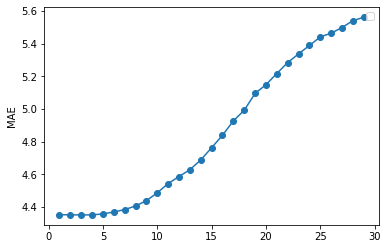

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) #
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 


total_scores = []
for i in range(1,30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i)
    # verificar cada uno de los modelos con validación cruzada.
    for train_fold, test_fold in cv.split(train_rs):
      # División train test aleatoria
      f_train = train_ss.loc[train_fold]
      f_test = train_ss.loc[test_fold]
      # entrenamiento y ejecución del modelo
      dt.fit( X = f_train.drop(['playResult'], axis=1), 
                            y = f_train['playResult'])
      y_pred = dt.predict(X = f_test.drop(['playResult'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['playResult'], y_pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value  :' +  str(min(total_scores)) +' (' + str(np.argmin(total_scores) + 1) + ')')
plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_rs.drop(["playResult"],axis=1),train_rs["playResult"],test_size=0.2)

In [ ]:
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
mae = mean_absolute_error(y_test, y_pred)
print ('MAE', mae)


MAE 4.280850446353303


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



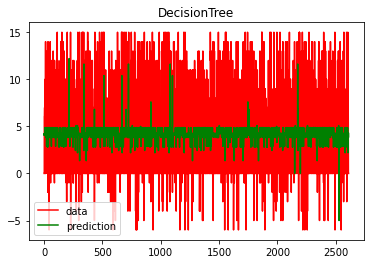

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

###Ejecución train vs train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_rs.drop(["playResult"],axis=1),train_rs["playResult"],test_size=0.2)

In [ ]:
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_train)
mae = mean_absolute_error(y_train, y_pred)
print ('MAE', mae)


MAE 7.648202876469783


arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


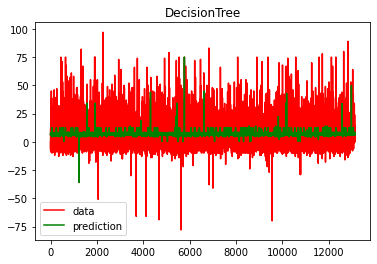

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_train.shape[0]))
plt.plot(xx, y_train, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

##PowerTransformer

In [ ]:
train_pt = pd.DataFrame(X_pca_pt)
train_pt["playResult"] = static_defenses["playResult"].values
train_pt.head()

0         1         2         3         4         5         6  \
0 -0.877362  2.536184 -0.731284 -1.983848 -1.957887  0.235809 -1.935399   
1 -0.223881  1.782451 -1.518003  0.172209  1.013185 -0.196966 -2.288539   
2  2.604492  2.608139  3.189280 -2.094266 -0.517080  0.608544 -0.983826   
3 -1.877553  1.532802 -2.591915  2.058908  0.022966  1.421198 -1.603436   
4 -1.977252 -1.285616 -0.633152  0.990860 -2.097227  1.726617 -0.773689   

          7         8         9        10        11        12  playResult  
0  1.761012  2.255258  3.984618 -0.300023 -1.325439  0.292239          10  
1  0.173654  0.258325 -0.521700  0.159173  0.503148 -0.678501           0  
2 -0.235234 -3.568681  1.518837 -0.307486  0.628058 -0.253353           0  
3  2.024369 -0.546895 -1.234908  0.159644 -0.225626 -0.484360          33  
4  0.907789 -0.123990  0.066074 -0.248384 -0.595506  1.035280           4

No handles with labels found to put in legend.


Min Value  :4.352378349329421 (3)


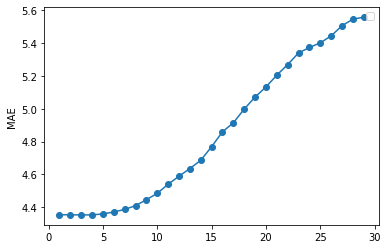

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np

cv = KFold(n_splits = 10, shuffle = False) #
#  https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html 


total_scores = []
for i in range(1,30):
    fold_accuracy = []
    dt = DecisionTreeRegressor(max_depth=i)
    # verificar cada uno de los modelos con validación cruzada.
    for train_fold, test_fold in cv.split(train_pt):
      # División train test aleatoria
      f_train = train_ss.loc[train_fold]
      f_test = train_ss.loc[test_fold]
      # entrenamiento y ejecución del modelo
      dt.fit( X = f_train.drop(['playResult'], axis=1), 
                            y = f_train['playResult'])
      y_pred = dt.predict(X = f_test.drop(['playResult'], axis = 1))
      # evaluación del modelo
      mae = mean_absolute_error(f_test['playResult'], y_pred)
      fold_accuracy.append(mae)
    total_scores.append(sum(fold_accuracy)/len(fold_accuracy))
   
plt.plot(range(1,len(total_scores)+1), total_scores, 
           marker='o')
print ('Min Value  :' +  str(min(total_scores)) +' (' + str(np.argmin(total_scores) + 1) + ')')
plt.ylabel('MAE')      
    

plt.legend()
plt.show() 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_pt.drop(["playResult"],axis=1),train_pt["playResult"],test_size=0.2)

In [ ]:
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_test)
mae = mean_absolute_error(y_test, y_pred)
print ('MAE', mae)


MAE 4.401389778919136


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



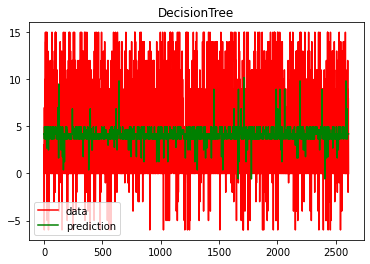

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_test.shape[0]))
plt.plot(xx, y_test, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

###Ejecución train vs train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_pt.drop(["playResult"],axis=1),train_pt["playResult"],test_size=0.2)

In [ ]:
regressor = DecisionTreeRegressor(max_depth=5)
regressor.fit( X = X_train, y = y_train)
y_pred = regressor.predict(X = X_train)
mae = mean_absolute_error(y_train, y_pred)
print ('MAE', mae)


MAE 7.787856659263081


arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


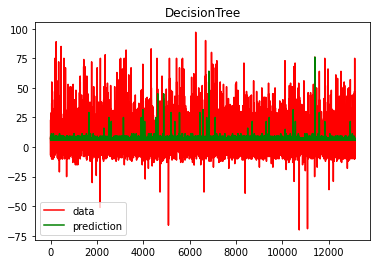

In [ ]:
from sklearn.metrics import mean_absolute_error

                    
# x axis for plotting
import numpy as np
xx = np.stack(i for i in range(y_train.shape[0]))
plt.plot(xx, y_train, c='r', label='data')
#plt.plot(xx, y, c='k', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("DecisionTree")

plt.show()

#RandomForest

##StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ss.drop(["playResult"],axis=1),train_ss["playResult"],test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#1.1 Model Parametrization 
regressor = RandomForestRegressor(n_estimators= 100, max_depth = 10, criterion='mae', random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_test)

# metrics calculation 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test,y_pred)
print ("Error Measure ",  mae)

Error Measure  7.620924459335974


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



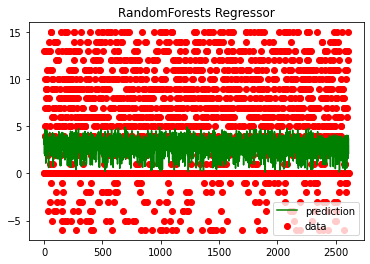

In [ ]:
#plt.subplot(2, 1, i + 1)
# x axis for plotting
import matplotlib.pyplot as plt
import numpy as np

xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

###Ejecución train vs train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ss.drop(["playResult"],axis=1),train_ss["playResult"],test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#1.1 Model Parametrization 
regressor = RandomForestRegressor(n_estimators= 100, max_depth = 10, criterion='mae', random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_train)

# metrics calculation 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(X_train,y_pred)
print ("Error Measure ",  mae)

ValueError: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



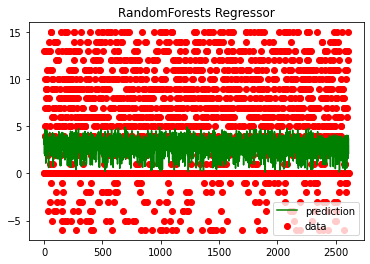

In [ ]:
#plt.subplot(2, 1, i + 1)
# x axis for plotting
import matplotlib.pyplot as plt
import numpy as np

xx = np.stack(i for i in range(len(y_train)))
plt.scatter(xx, y_train, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

##MinMaxScaler

###Ejecución train vs train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_mms.drop(["playResult"],axis=1),train_mms["playResult"],test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#1.1 Model Parametrization 
regressor = RandomForestRegressor(n_estimators= 100, max_depth = 10, criterion='mae', random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_train)

# metrics calculation 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(x_train,y_pred)
print ("Error Measure ",  mae)

Error Measure  7.214479896436186


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



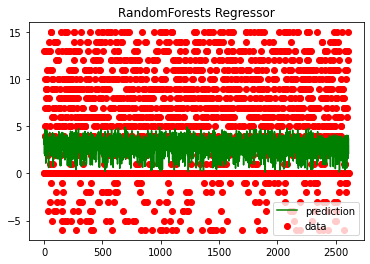

In [ ]:
#plt.subplot(2, 1, i + 1)
# x axis for plotting
import matplotlib.pyplot as plt
import numpy as np

xx = np.stack(i for i in range(len(y_train)))
plt.scatter(xx, y_train, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

##RobustScaler

###Ejecución train vs train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_rs.drop(["playResult"],axis=1),train_rs["playResult"],test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#1.1 Model Parametrization 
regressor = RandomForestRegressor(n_estimators= 100, max_depth = 10, criterion='mae', random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_train)

# metrics calculation 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(x_train,y_pred)
print ("Error Measure ",  mae)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



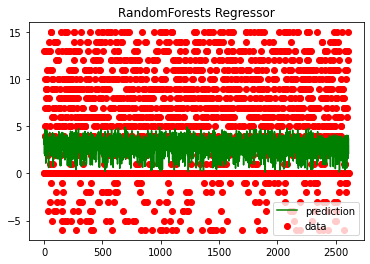

In [ ]:
#plt.subplot(2, 1, i + 1)
# x axis for plotting
import matplotlib.pyplot as plt
import numpy as np

xx = np.stack(i for i in range(len(y_train)))
plt.scatter(xx, y_train, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

##PowerTransformer

###Ejecución train vs train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_pt.drop(["playResult"],axis=1),train_pt["playResult"],test_size=0.2)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

#1.1 Model Parametrization 
regressor = RandomForestRegressor(n_estimators= 100, max_depth = 10, criterion='mae', random_state=0)
#1.2 Model construction
regressor.fit(X_train, y_train)

# Test
y_pred = regressor.predict(X_train)

# metrics calculation 
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(x_train,y_pred)
print ("Error Measure ",  mae)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



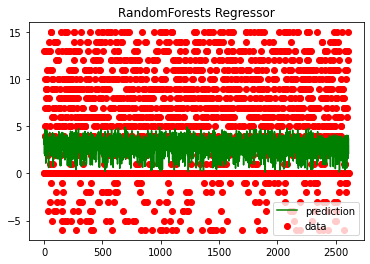

In [ ]:
#plt.subplot(2, 1, i + 1)
# x axis for plotting
import matplotlib.pyplot as plt
import numpy as np

xx = np.stack(i for i in range(len(y_train)))
plt.scatter(xx, y_train, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("RandomForests Regressor")

plt.show()

#Boosting

##StandardScaler

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_ss.drop(["playResult"],axis=1),train_ss["playResult"],test_size=0.2)

In [ ]:
from sklearn.ensemble import AdaBoostRegressor  
regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5, criterion='mae'),n_estimators=100)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
print("Error Measure", mean_absolute_error(y_test,y_pred))

Error Measure 4.69609345078514


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2822: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



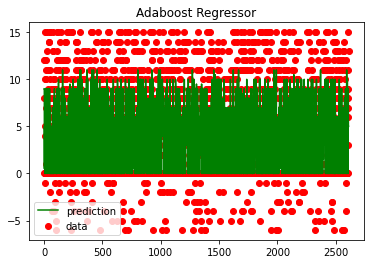

In [ ]:
xx = np.stack(i for i in range(len(y_test)))
plt.scatter(xx, y_test, c='r', label='data')
plt.plot(xx, y_pred, c='g', label='prediction')
plt.axis('tight')
plt.legend()
plt.title("Adaboost Regressor")

plt.show()

##MinMaxScaler

##RobustScaler

##PowerTransformer